In [1]:
# -*- coding: utf-8 -*-
# Create time: 2025-09-28
# Update time: 2025-11-27

# conda activate benchmark
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import List
plt.rcParams['svg.fonttype'] = 'none'

# cm 转 inch
cm_to_inch = 1 / 2.54

class EmbeddingMetrics:
    def __init__(self, df: pd.DataFrame):
        """
        直接用 DataFrame 构造：
        第一行为某 embedding 的指标值，最后一行为 metric 类型
        """
        self.metric_values = df.iloc[0:1].copy()
        self.metric_types = df.iloc[1:2].copy()
        self.embedding_name = self.metric_values.index[0]

    @classmethod
    def from_file(cls, filepath: str):
        df = pd.read_csv(filepath, index_col=0)
        return cls(df)

    def get_value(self, col_name: str) -> float | None:
        """返回指定指标的数值"""
        if col_name in self.metric_values.columns:
            return float(self.metric_values[col_name].values[0])
        else:
            print(f"[Warning] 指标列 '{col_name}' 不存在。")
            return None

    def rename_embedding(self, new_name: str):
        """修改 embedding 名称"""
        self.metric_values.index = [new_name]
        self.embedding_name = new_name

    def add_column(self, col_name: str, col_type: str, value: float):
        """添加新的一列指标及其类型，按指标类型插入到对应位置"""
        if col_name in self.metric_values.columns:
            print(f"[Warning] 列 '{col_name}' 已存在，跳过添加。")
            return

        # 获取所有当前指标列
        all_cols = list(self.metric_values.columns)

        # 找到相同类型的最后一个列的索引位置
        insert_idx = None
        for i, col in enumerate(all_cols):
            if self.metric_types[col].values[0] == col_type:
                insert_idx = i + 1  # 插入到这个后面

        # 若找不到同类指标，就加到最前或最后
        if insert_idx is None:
            insert_idx = 0  # 默认插在最前（也可以改为 len(all_cols) 插最后）

        # 插入到指定位置
        for df in [self.metric_values, self.metric_types]:
            df.insert(loc=insert_idx, column=col_name, value=value if df is self.metric_values else col_type)

    def delete_column(self, col_name: str):
        """从指标中删除指定列（指标值和类型都一起删）"""
        if col_name in self.metric_values.columns:
            self.metric_values.drop(columns=[col_name], inplace=True)
            self.metric_types.drop(columns=[col_name], inplace=True)
        else:
            print(f"[Warning] 列名 '{col_name}' 不存在，跳过删除。")

    def filter_columns(self, keep_cols: List[str]):
        """
        只保留指定的指标列（指标值和类型都一起筛选）
        """
        current_cols = set(self.metric_values.columns)
        keep_set = set(keep_cols)
        drop_cols = list(current_cols - keep_set)
        self.metric_values.drop(columns=drop_cols, inplace=True)
        self.metric_types.drop(columns=drop_cols, inplace=True)

    def update_value(self, col_name: str, new_value: float):
        """更新已有指标的数值"""
        self.metric_values[col_name] = new_value

    def compute_scores(self, weights: dict = None):
        """
        自动计算三类 Aggregate Score：
        1. Bio conservation: 平均值
        2. Batch correction: 平均值
        3. Total: 加权平均
        """
        if weights is None:
            weights = {
                "Bio conservation": 0.6,
                "Batch correction": 0.4 
            }

        bio_cols = [c for c in self.metric_values.columns if self.metric_types[c].values[0] == "Bio conservation"]
        batch_cols = [c for c in self.metric_values.columns if self.metric_types[c].values[0] == "Batch correction"]

        bio_score = self.metric_values[bio_cols].astype(float).mean(axis=1).values[0] if bio_cols else 0
        batch_score = self.metric_values[batch_cols].astype(float).mean(axis=1).values[0] if batch_cols else 0

        self.metric_values["Bio conservation"] = bio_score
        self.metric_types["Bio conservation"] = "Aggregate score"

        self.metric_values["Batch correction"] = batch_score
        self.metric_types["Batch correction"] = "Aggregate score"

        total_score = bio_score * weights["Bio conservation"] + batch_score * weights["Batch correction"]
        self.metric_values["Total"] = total_score
        self.metric_types["Total"] = "Aggregate score"

    def to_dataframe(self) -> pd.DataFrame:
        return pd.concat([self.metric_values, self.metric_types])

    @staticmethod
    def merge_embeddings(objs: List["EmbeddingMetrics"]) -> pd.DataFrame:
        """
        将多个 EmbeddingMetrics 合并为一个 DataFrame：
        多行指标 + 一行 Metric Type
        """
        rows = [obj.metric_values for obj in objs]
        types = objs[0].metric_types.copy()  # 假设类型一致
        df = pd.concat(rows + [types])
        return df


In [2]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/limb/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/limb/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/limb/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/limb/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/limb/uce"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/limb/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/limb/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/limb/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/genecompass"},

]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    # m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "KBET", "Graph connectivity"])

    # # 计算 aggregate 分数
    # m.compute_scores(weights={
    #     "Bio conservation": 0.6,
    #     "Batch correction": 0.4
    # })

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_limb = EmbeddingMetrics.merge_embeddings(metrics_all)


In [3]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/Immune/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/Immune/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/Immune/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/Immune/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/Immune/uce"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/Immune/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/Immune/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/Immune/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    # m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "KBET", "Graph connectivity"])

    # # 计算 aggregate 分数
    # m.compute_scores(weights={
    #     "Bio conservation": 0.6,
    #     "Batch correction": 0.4
    # })

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })
    metrics_all.append(m)

# 合并所有模型
merged_df_immune = EmbeddingMetrics.merge_embeddings(metrics_all)


In [4]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/liver/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/liver/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/liver/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/liver/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/liver/uce"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/liver/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/liver/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/liver/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_liver = EmbeddingMetrics.merge_embeddings(metrics_all)


In [5]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_assay/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_assay/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_assay/uce"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_assay/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_assay/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_assay/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/genecompass"},
]


metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_HLCA_assay = EmbeddingMetrics.merge_embeddings(metrics_all)

In [6]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_disease/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_disease/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_disease/uce"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_disease/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_disease/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_disease/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_HLCA_disease = EmbeddingMetrics.merge_embeddings(metrics_all)

In [7]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_sn/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_sn/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_sn/uce"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_sn/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_sn/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_sn/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_HLCA_sn = EmbeddingMetrics.merge_embeddings(metrics_all)

In [12]:
def plot_batch_comparison_line(dataset_configs, figsize=(10, 8), save_dir=None):
    """
    绘制多个数据集的原始模型vs批次处理模型比较折线图
    
    Parameters:
    -----------
    dataset_configs : list of dict
        数据集配置列表，每个字典包含：
        - 'merged_df': 合并后的DataFrame
        - 'title': 子图标题
        - 'threshold': 虚线阈值
    figsize : tuple
        图像大小
    save_dir : str, optional
        图片保存路径
    """
    
    # 定义基础模型列表（按顺序用于图例排列）
    foundation_models = ['scCello', 'Nicheformer', 'scGPT', 'CellPLM', 'GeneCompass', 'scFoundation', 'Geneformer', 'UCE']
    
    # 定义颜色
    model_colors = {
        'Harmony': '#FF8E53', 
        'PCA': '#26C281',
        'Scanorama': '#FF6B6B',
        'scVI': '#4ECDC4',
        'UCE': '#FFA502',
        'Geneformer': '#2F3542',
        'CellPLM': '#FF4757',        
        'scGPT': '#45B7D1',
        'scFoundation': '#3742FA',
        'Nicheformer': '#A4B0BE',
        'scCello': "#DB45F9",
        'GeneCompass': "#B9CF0F",
    }
    
    # 全局字体设置
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 6
    plt.rc('lines', linewidth=0.5)

    n_datasets = len(dataset_configs)
    # 2 行 3 列
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # 将 axes 展平成一维列表方便遍历
    axes_flat = axes.flatten()
    
    # 用于收集所有模型信息（用于创建统一的图例）
    all_models_info = {}
    
    for idx, config in enumerate(dataset_configs):
        ax = axes_flat[idx]
        merged_df = config['merged_df']
        threshold = config.get('threshold', 0.5)  # 默认阈值为 0.5
        
        # 从merged_df中提取数据（排除最后的Metric Type行）
        data = merged_df.iloc[:-1].copy()
        
        # 分离原始模型和batch模型
        original_models = []
        batch_models = []
        
        for model_idx, row in data.iterrows():
            if '_batch' in model_idx:
                batch_models.append({'name': model_idx.replace('_batch', ''), 'total': row['Total']})
            else:
                original_models.append({'name': model_idx, 'total': row['Total']})
        
        # 匹配原始模型和对应的batch模型
        for orig in original_models:
            # 查找对应的batch模型
            for batch in batch_models:
                if orig['name'] == batch['name']:
                    # 确定颜色
                    if orig['name'] in model_colors:
                        color = model_colors[orig['name']]
                    else:
                        color = '#95A5A6'  # 默认灰色
                    
                    # 绘制折线：0 到 1 (before 到 after)
                    ax.plot([0, 1], [orig['total'], batch['total']], 
                            color=color, marker='o', markersize=3, linewidth=0.75, alpha=0.9)
                    
                    # 收集模型信息用于图例（只收集一次，避免重复）
                    if orig['name'] not in all_models_info:
                        all_models_info[orig['name']] = {
                            'color': color,
                            'marker': 'o'
                        }
                    break
        
        # 设置x轴标签和范围，留出左右空间
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['before', 'after'], fontsize=6)
        ax.set_xlim(-0.3, 1.3)  # 留出左右空间，避免点与边框重叠
        
        # 动态计算y轴范围
        all_totals = [orig['total'] for orig in original_models] + [batch['total'] for batch in batch_models]
        if all_totals:
            y_min, y_max = min(all_totals), max(all_totals)
            data_min = min(y_min, threshold)
            data_max = max(y_max, threshold)
            margin = (data_max - data_min) * 0.1
            axis_min = max(0, data_min - margin)
            axis_max = min(1, data_max + margin)
            ax.set_ylim(axis_min, axis_max)
        
        # 添加横向红色虚线代表阈值
        ax.axhline(y=threshold, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        
        # 设置子图标题
        ax.set_title(config['title'], fontsize=7, fontweight='bold')
        
        # 第五个图显示x轴标签
        if idx == 4:
            ax.set_xlabel('Cell Embeddings Before/After Batch-Centralization', fontsize=7)
        
        # 坐标轴刻度大小
        ax.tick_params(axis='both', which='major', labelsize=6, width=0.5, pad=1, length=2)

        # 添加网格
        ax.grid(True, alpha=0.3)
    
    # 隐藏多余的子图（如果少于 6 个数据集）
    for idx in range(n_datasets, 6):
        axes_flat[idx].axis('off')
    
    # 创建统一的图例 - 按 foundation_models 列表顺序排列
    legend_elements = []
    
    for model_name in foundation_models:
        if model_name in all_models_info:
            info = all_models_info[model_name]
            legend_elements.append(plt.Line2D([0], [0], marker=info['marker'], color='w',
                                            markerfacecolor=info['color'], markersize=4,
                                            label=model_name, linestyle='None'))
    
    # 添加其他模型（不在foundation_models列表中的）
    for model_name, info in sorted(all_models_info.items()):
        if model_name not in foundation_models:
            legend_elements.append(plt.Line2D([0], [0], marker=info['marker'], color='w',
                                            markerfacecolor=info['color'], markersize=4,
                                            label=model_name, linestyle='None'))

    # 添加虚线图例说明
    legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=0.8,
                                     label='Harmony scIB score', markersize=3, alpha=0.5))

    # 图例放在图下方，分成三列
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08),
               frameon=False, handletextpad=0.1, labelspacing=0.2, columnspacing=1, fontsize=6, ncol=3)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.23)  # 为下方图例留出空间

    # 在整个图的左侧中间添加共享ylabel
    fig.text(0.01, 0.5, 'scIB Score', 
             va='center', ha='center', rotation='vertical', fontsize=7)
    
    # 保存图像
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "Figure2G_batch_normalize_scib_line.pdf"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, "Figure2G_batch_normalize_scib_line.svg"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, "Figure2G_batch_normalize_scib_line.jpg"), dpi=600, bbox_inches="tight")

    plt.show()

    return None

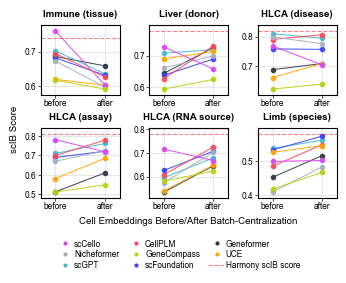

In [13]:
# 准备数据集配置
dataset_configs = [
    {
        'merged_df': merged_df_immune,  
        'title': 'Immune (tissue)',
        'threshold': 0.74
    },
    {
        'merged_df': merged_df_liver, 
        'title': 'Liver (donor)',
        'threshold': 0.78
    },
    {
        'merged_df': merged_df_HLCA_disease,  
        'title': 'HLCA (disease)',
        'threshold': 0.82
    },
    {
        'merged_df': merged_df_HLCA_assay,  
        'title': 'HLCA (assay)',
        'threshold': 0.81
    },
    {
        'merged_df': merged_df_HLCA_sn,  
        'title': 'HLCA (RNA source)',
        'threshold': 0.78
    },
    {
        'merged_df': merged_df_limb,  
        'title': 'Limb (species)',
        'threshold': 0.58
    },
]

# 绘制比较图
plot_batch_comparison_line(
    dataset_configs,
    figsize=(8.5*cm_to_inch, 6.5*cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure"
)